<a href="https://colab.research.google.com/github/elka97/pythonLibrariesCourse/blob/main/realestate_moscow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение библиотек и скриптов

In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [132]:
import numpy as np
import pandas as pd
import random
from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

#  pre-processing pipelines
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin 

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 12})

In [133]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50 

In [180]:
DATASET_PATH = ''
SUBMIT_DATASET_PATH = ''
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'


# #  my google disk
# DATASET_PATH = "/gdrive/My Drive/datasets/"

# TRAIN_DATASET_PATH = DATASET_PATH +"real-estate-price-prediction-moscow/train.csv"
# TEST_DATASET_PATH = DATASET_PATH +"real-estate-price-prediction-moscow/test.csv"
# SUBMIT_DATASET_PATH = DATASET_PATH +"real-estate-price-prediction-moscow/sample_submission.csv"

In [135]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

def extract_metadata(df_columns, ind_prefix):    
    columns = [el for el in df_columns if (el.startswith(ind_prefix.capitalize()) or el.startswith(ind_prefix) or str(el).lower().startswith(ind_prefix.lower()))]
    if len(columns) == 0:
        print(f"No {ind_prefix} found.")
    return columns
    
def drop_extra_cols(d, droplist): 
  print(f"Dropping columns {droplist}") 
  df1 = d.drop(columns=droplist, axis=1, errors='ignore')
  return df1

def get_X_y(data):
  X = data.drop(columns=[TARGET_NAME], axis=1, errors='ignore')
  y = data[TARGET_NAME]
  return X, y

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def load_data():
  train_df = pd.read_csv(TRAIN_DATASET_PATH)
  test_df = pd.read_csv(TEST_DATASET_PATH)
  train_df = reduce_mem_usage(train_df)
  test_df = reduce_mem_usage(test_df)
  print(train_df.shape, test_df.shape )
  return train_df, test_df

def check_outliers(df):
  print(f"HouseYear: [{df.HouseYear.min()}<=>{df['HouseYear'].max()}]")
  print(f"Floor: [{df.Floor.min()}<=>{df['Floor'].max()}] floor/housefloor {df.loc[df['Floor'] > df['HouseFloor'], 'Floor']}")
  print(f"Rooms: [{df.Rooms.min()}<=>{df['Rooms'].max()}]")
  print(f"Square: [{df.Square.min()}<=>{df['Square'].max()}]")
  print(f"LifeSquare: [{df.LifeSquare.min()} <=>{df['LifeSquare'].max()}] LifeSquare/Square: {df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare']} nan: {df.loc[df['LifeSquare'].isna(), 'LifeSquare']}") 
  print(f"KitchenSquare: [{df.KitchenSquare.min()} <=> {df['KitchenSquare'].max()}] KitchenSquare>LifeSquare: {df.loc[df['KitchenSquare'] > df['LifeSquare'], 'KitchenSquare']} KitchenSquare>(Square-LifeSquare): {df.loc[df['KitchenSquare'] > (df['Square']-df['LifeSquare']), 'KitchenSquare']} nan: {df.loc[df['KitchenSquare'].isna(), 'KitchenSquare']}")
  print(f"Healthcare_1: [{df.Healthcare_1.min()} <=> {df['Healthcare_1'].max()}] nan: {df.loc[df['Healthcare_1'].isna(), 'Healthcare_1']}")

In [136]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Загрузка данных

In [137]:
train_df, test_df = load_data()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%
(10000, 20) (5000, 19)


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Contants

In [139]:
TARGET_NAME = 'Price'

## 1. EDA  <a class='anchor' id='eda'>

In [140]:
for col in train_df.columns:
  uniq = train_df[col].sort_values().unique()
  counter = Counter(train_df[col])
  print(f"{col} values: {len(counter)} missing: {train_df[col].isnull().sum()}")

Id values: 10000 missing: 0
DistrictId values: 205 missing: 0
Rooms values: 9 missing: 0
Square values: 9995 missing: 0
LifeSquare values: 9999 missing: 2113
KitchenSquare values: 58 missing: 0
Floor values: 33 missing: 0
HouseFloor values: 44 missing: 0
HouseYear values: 97 missing: 0
Ecology_1 values: 129 missing: 0
Ecology_2 values: 2 missing: 0
Ecology_3 values: 2 missing: 0
Social_1 values: 51 missing: 0
Social_2 values: 142 missing: 0
Social_3 values: 30 missing: 0
Healthcare_1 values: 4877 missing: 4798
Helthcare_2 values: 7 missing: 0
Shops_1 values: 16 missing: 0
Shops_2 values: 2 missing: 0
Price values: 9996 missing: 0


In [141]:
train_df = drop_extra_cols(train_df, ['Id'])

Dropping columns ['Id']


**Целевая переменная**

target_mean: 214138.94
target_median: 192269.65625
target_mode: 182938.078125


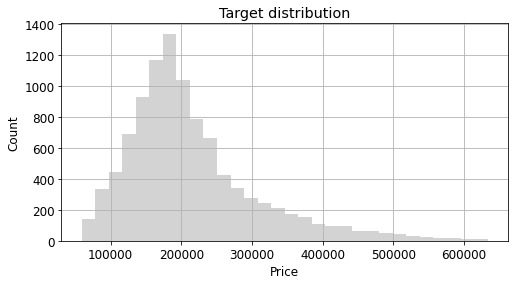

In [142]:
target_mean = round(train_df[TARGET_NAME].mean(), 2)
target_median = train_df[TARGET_NAME].median()
target_mode = train_df[TARGET_NAME].mode()[0]
target_mean, target_median, train_df[TARGET_NAME].mode()
y_length = len(train_df[TARGET_NAME])
print(f"target_mean: {target_mean}\ntarget_median: {target_median}\ntarget_mode: {target_mode}")
plt.figure(figsize = (8, 4))
train_df[TARGET_NAME].hist(bins=30, color="lightgrey")
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

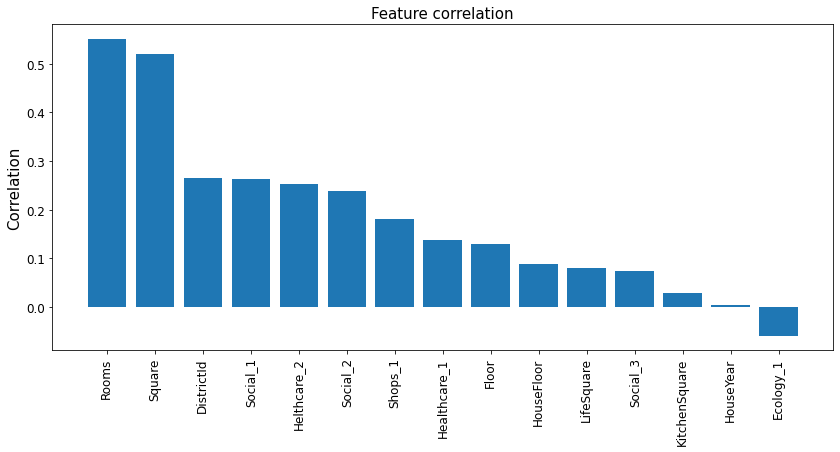

In [143]:
correlation = train_df.corrwith(train_df[TARGET_NAME]).sort_values(ascending=False)
correlation.drop(TARGET_NAME, inplace=True)
plt.figure(figsize = (14, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
# plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [144]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [145]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [146]:
# validate 
# маскимальная площадь 641.065193 меньше максимальной жилой площади 7480.592129
# маскимальный размер кухни тоже имеет странные размеры 2014.000000
# Этажность 117 этажей
# HouseYear - 2.005201e+07
# Rooms ==0

**Square**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5002891910>,
 count    10000.000000
 mean        56.315720
 std         21.058716
 min          1.136859
 25%         41.774879
 50%         52.513309
 75%         65.900627
 max        641.065186
 Name: Square, dtype: float64)

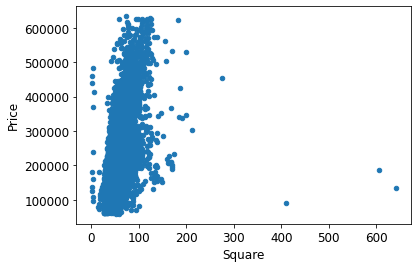

In [147]:
var = 'Square'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df[var].describe()

In [148]:
out= train_df.loc[(train_df['Square']<10) | (train_df['Square'] > 400)]
out.shape

(15, 19)

**HouseYear**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f500066c750>,
 count    1.000000e+04
 mean     3.990166e+03
 std      2.005003e+05
 min      1.910000e+03
 25%      1.974000e+03
 50%      1.977000e+03
 75%      2.001000e+03
 max      2.005201e+07
 Name: HouseYear, dtype: float64)

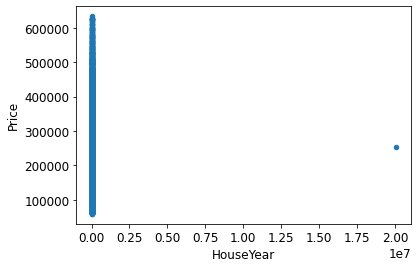

In [149]:
var = 'HouseYear'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df['HouseYear'].describe()

In [150]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

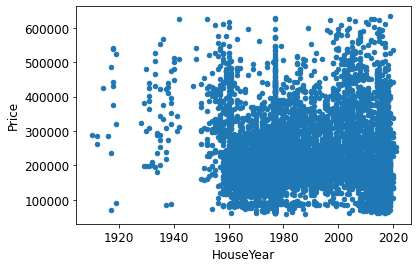

In [151]:
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME) 

**HouseFloor, Floor**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5000699e50>, count    10000.0000
 mean        12.6094
 std          6.7762
 min          0.0000
 25%          9.0000
 50%         13.0000
 75%         17.0000
 max        117.0000
 Name: HouseFloor, dtype: float64)

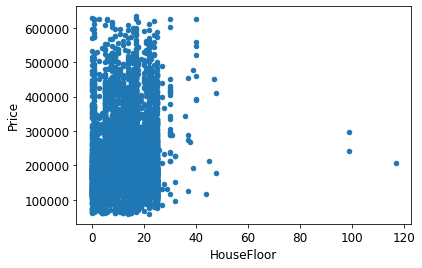

In [152]:
var = 'HouseFloor'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df[var].describe()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4ffe8874d0>,
 count    10000.000000
 mean         8.526700
 std          5.241148
 min          1.000000
 25%          4.000000
 50%          7.000000
 75%         12.000000
 max         42.000000
 Name: Floor, dtype: float64)

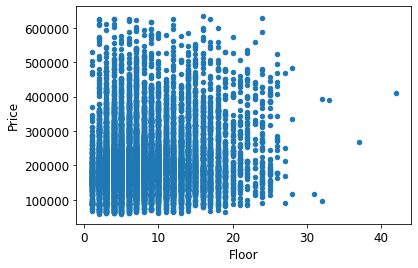

In [153]:
var = 'Floor'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df[var].describe()

In [154]:
wrong_floor = train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])]
wrong_floor.shape

(1825, 19)

**Rooms**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f50008c3550>,
 (count    10000.000000
  mean         1.890500
  std          0.839522
  min          0.000000
  25%          1.000000
  50%          2.000000
  75%          2.000000
  max         19.000000
  Name: Rooms, dtype: float64, 2.0     3880
  1.0     3705
  3.0     2235
  4.0      150
  5.0       18
  0.0        8
  10.0       2
  19.0       1
  6.0        1
  Name: Rooms, dtype: int64))

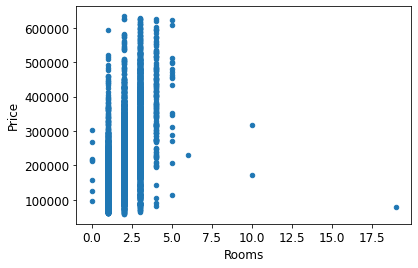

In [155]:
var = 'Rooms'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), (train_df[var].describe(), train_df[var].value_counts()) 

In [156]:
out=train_df.loc[(train_df['Rooms'] == 0)]
out.shape

(8, 19)

In [157]:
out=train_df.loc[(train_df['Rooms'] >6)] 
out.shape

(3, 19)

**LifeSquare**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4ffe655910>,
 count    7887.000000
 mean       37.199665
 std        86.241219
 min         0.370619
 25%        22.769833
 50%        32.781261
 75%        45.128803
 max      7480.592285
 Name: LifeSquare, dtype: float64)

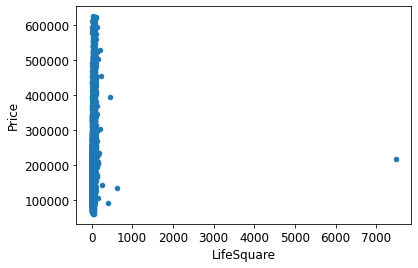

In [158]:
var = 'LifeSquare'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df.LifeSquare.describe()

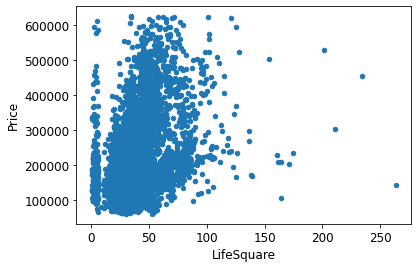

In [159]:
clean_lifesuqare = train_df.iloc[train_df.loc[((train_df['LifeSquare'].isnull()==False)&(train_df['LifeSquare'] >0)&(train_df['LifeSquare'] < 400))].index]

data1 = pd.concat([clean_lifesuqare[TARGET_NAME], clean_lifesuqare[var]], axis=1)
data1.plot.scatter(x=var, y=TARGET_NAME)

In [160]:
lifesquare_outliers = train_df.loc[train_df['LifeSquare'] > train_df['Square']]
lifesquare_outliers.shape

(482, 19)

In [161]:
# looks like in those records Square and LifeSquare misordered; swap needed
lifesquare_outliers.sample(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
834,74,1.0,48.166393,50.044327,0.0,3,16.0,2018,0.075779,B,B,6,1437,3,NaN,0,2,B,167878.015625
7133,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.140625
8021,27,1.0,44.611000,45.512390,10.0,4,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,140685.562500
6116,27,2.0,34.665783,36.079449,9.0,3,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,103182.851562
4336,27,1.0,37.814663,41.650139,10.0,20,22.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,86887.140625


**KitchenSquare**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4ffc867d10>,
 count    10000.000000
 mean         6.273300
 std         28.560839
 min          0.000000
 25%          1.000000
 50%          6.000000
 75%          9.000000
 max       2014.000000
 Name: KitchenSquare, dtype: float64,
 0,
 pandas.core.series.Series)

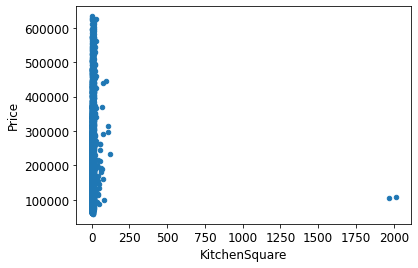

In [162]:
var = 'KitchenSquare'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME),train_df[var].describe(), train_df[var].isnull().sum(), type(train_df[var])

In [163]:
clean_kitchen = train_df.loc[train_df[var] < 60] 
clean_kitchen.shape

(9985, 19)

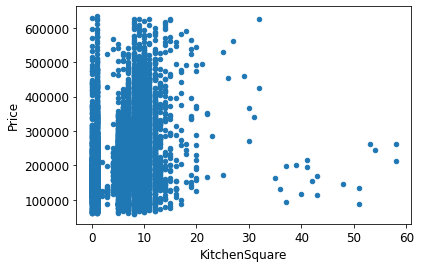

In [164]:
data1 = pd.concat([clean_kitchen[TARGET_NAME], clean_kitchen[var]], axis=1)
data1.plot.scatter(x=var, y=TARGET_NAME)

**Категориальные переменные**

**Healthcare_1**

(array([1354., 1277., 1224.,  314.,  409.,  369.,   43.,   42.,   82.,
          88.]),
 array([   0. ,  484.9,  969.8, 1454.7, 1939.6, 2424.5, 2909.4, 3394.3,
        3879.2, 4364.1, 4849. ], dtype=float32),
 <a list of 10 Patch objects>)

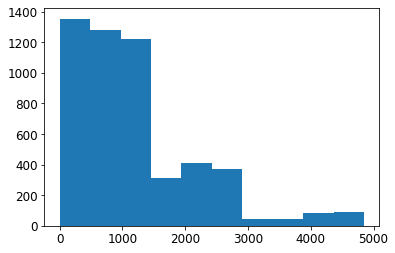

In [165]:
plt.hist(train_df.Healthcare_1)

**DistrictId**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5000b851d0>,
 count    10000.000000
 mean        50.400800
 std         43.587592
 min          0.000000
 25%         20.000000
 50%         36.000000
 75%         75.000000
 max        209.000000
 Name: DistrictId, dtype: float64)

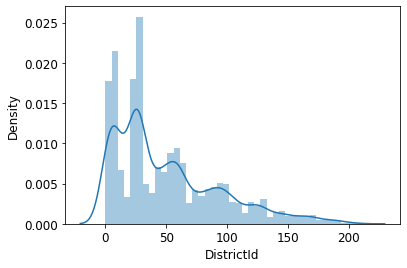

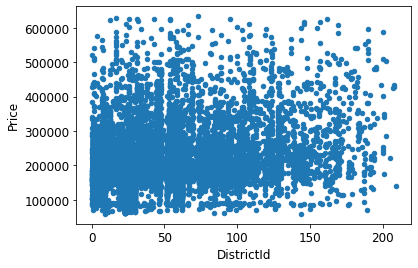

In [166]:
var = 'DistrictId'
sns.distplot(train_df[var])
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df[var].describe()

**Feature/Target encoding**

No mean_price_dr_room found.
Dropping columns []


(<matplotlib.axes._subplots.AxesSubplot at 0x7f500042ed10>,
 count     10000.000000
 mean     214140.703125
 std       74586.117188
 min       78364.617188
 25%      166014.062500
 50%      198777.281250
 75%      248821.484375
 max      624156.000000
 Name: mean_price_dr_room, dtype: float64)

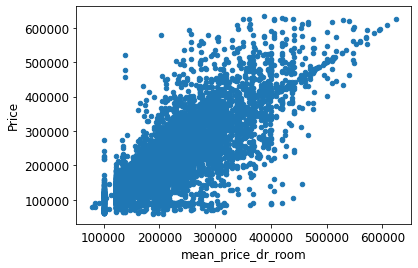

In [167]:
group = ['DistrictId', 'Rooms']
train_df = drop_extra_cols(train_df, extract_metadata(train_df.columns, 'mean_price_dr_room'))
info_by_district_id = train_df.groupby(group, as_index=False).agg({'Price': 'mean'}).rename(columns={'Price': 'mean_price_dr_room'})
train_df = pd.merge(train_df, info_by_district_id, on=group, how='left')

var = 'mean_price_dr_room'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME), train_df[var].describe()

Dropping columns ['median_houseyear_dr', 'mean_price_houseyear_dr', 'mean_sq_houseyear_dr']
No median_price_houseyear_dr found.
Dropping columns []


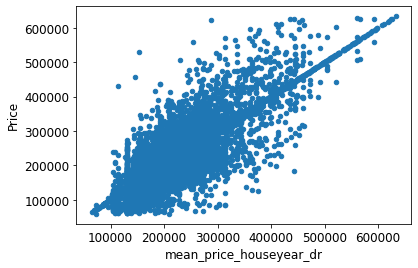

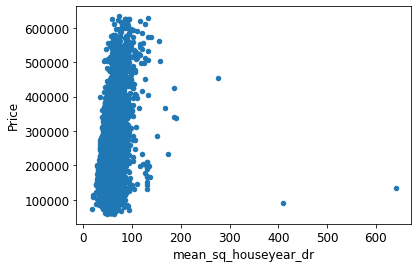

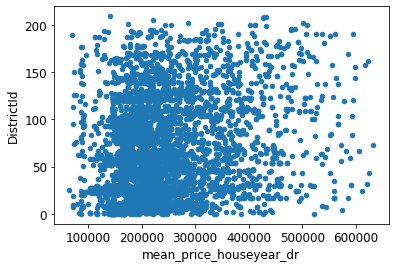

In [168]:
group=['DistrictId', 'HouseYear']
train_df = drop_extra_cols(train_df, ['median_houseyear_dr','mean_price_houseyear_dr','mean_sq_houseyear_dr'])

info_by_district_id = train_df.groupby(group, as_index=False).agg({'Price': 'mean', 'Square': 'mean', 'Rooms': 'median'}).rename(columns={'Price': 'mean_price_houseyear_dr', 'Square': 'mean_sq_houseyear_dr', 'Rooms': 'median_houseyear_dr' })
train_df = pd.merge(train_df, info_by_district_id, on=group, how='left')

train_df = drop_extra_cols(train_df, extract_metadata(train_df.columns, 'median_price_houseyear_dr'))
info_by_district_id = train_df.groupby(group, as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'median_price_houseyear_dr'})
train_df = pd.merge(train_df, info_by_district_id, on=group, how='left')

var = 'mean_price_houseyear_dr'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME) 

var = 'mean_sq_houseyear_dr'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME)

var = 'mean_price_houseyear_dr'
data = pd.concat([train_df['DistrictId'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='DistrictId')

Dropping columns ['mean_price_room_dr', 'median_Square_dr']


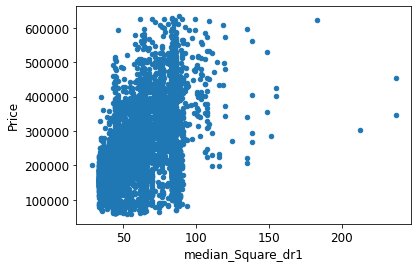

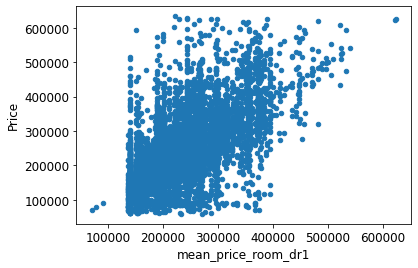

In [169]:
group = ['Rooms', 'HouseYear']
train_df = drop_extra_cols(train_df, ['mean_price_room_dr', 'median_Square_dr'])
info_by_district_id = train_df.groupby(group, as_index=False).agg({'Price': 'mean', 'Square': 'mean'}).rename(columns={'Price': 'mean_price_room_dr1', 'Square': 'median_Square_dr1'})
train_df = pd.merge(train_df, info_by_district_id, on=group, how='left')

var = 'median_Square_dr1'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME) 
 
var = 'mean_price_room_dr1'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME)

Dropping columns ['mean_Price_hy_hf_dr', 'mean_Square_hy_hf_dr', 'median_Rooms_hy_hf_dr']


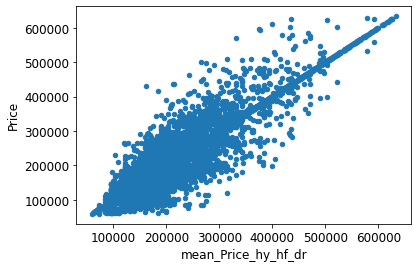

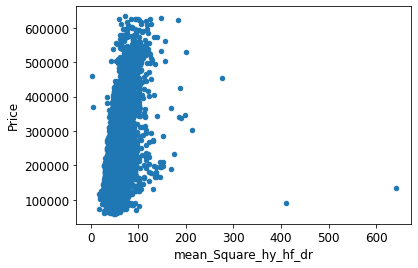

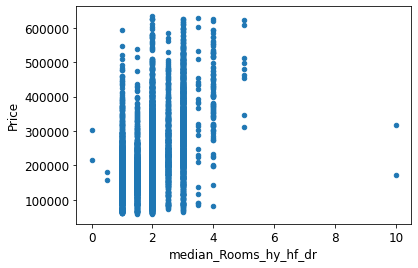

In [170]:
group=['DistrictId', 'HouseYear', 'HouseFloor']
train_df = drop_extra_cols(train_df, ['mean_Price_hy_hf_dr', 'mean_Square_hy_hf_dr', 'median_Rooms_hy_hf_dr'])
info_by_district_id = train_df.groupby(group, as_index=False).agg({'Price': 'mean', 'Square': 'mean', 'Rooms': 'median'}).rename(columns={'Price': 'mean_Price_hy_hf_dr', 'Square': 'mean_Square_hy_hf_dr','Rooms': 'median_Rooms_hy_hf_dr'})
info_by_district_id.sample(5)
train_df = pd.merge(train_df, info_by_district_id, on=group, how='left')

var = 'mean_Price_hy_hf_dr'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME) #, train_df[[var, 'median_Rooms_hy_hf_dr', 'mean_Square_hy_hf_dr', TARGET_NAME]].describe()

var = 'mean_Square_hy_hf_dr'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME)

var = 'median_Rooms_hy_hf_dr'
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
data.plot.scatter(x=var, y=TARGET_NAME)

# Слишком сильная корреляция с целевой переменной

**Ecology, Shops - category**

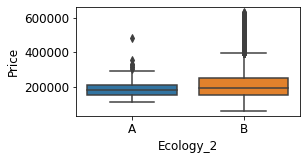

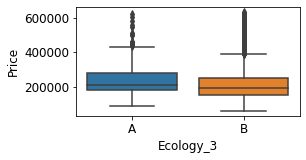

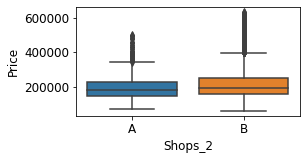

In [171]:
for var in train_df.select_dtypes(include=['category']).columns.tolist(): 
  data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
  f, ax = plt.subplots(figsize=(4, 2))
  fig = sns.boxplot(x=var, y=TARGET_NAME, data=data)

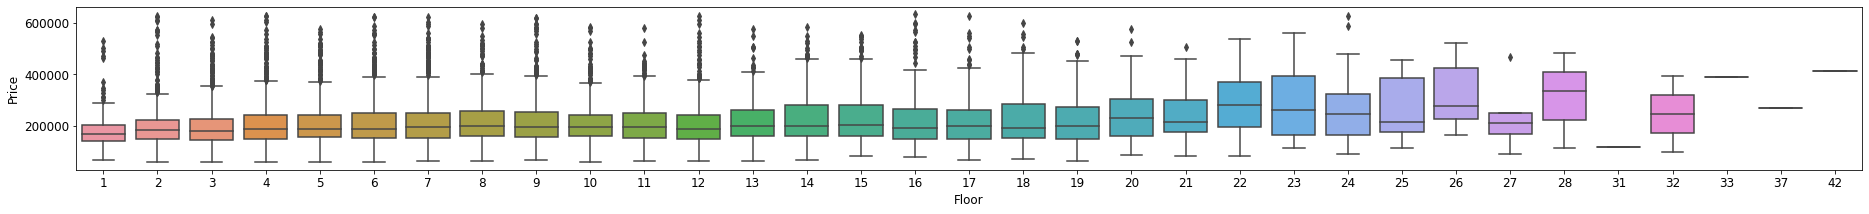

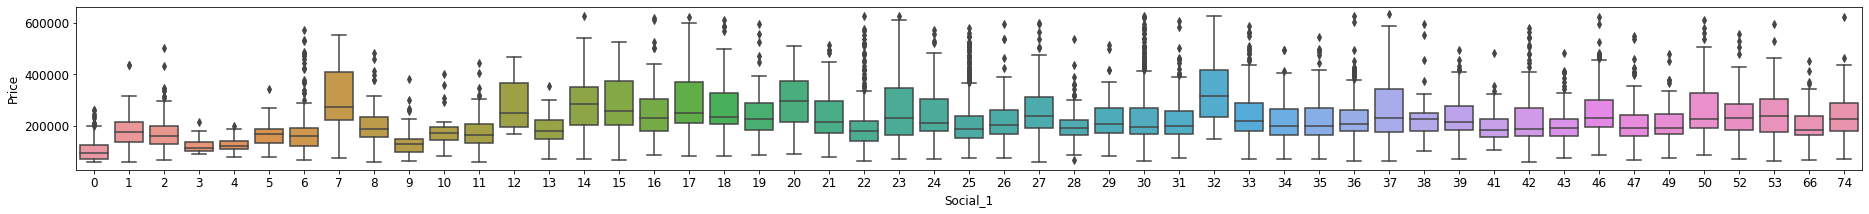

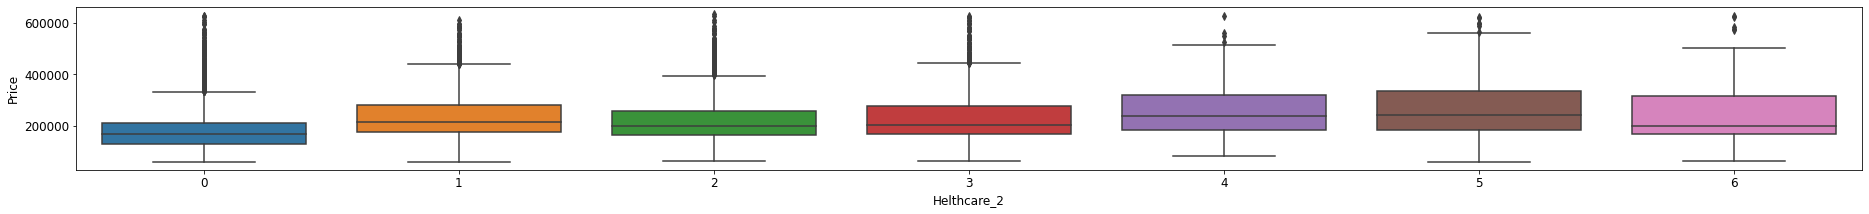

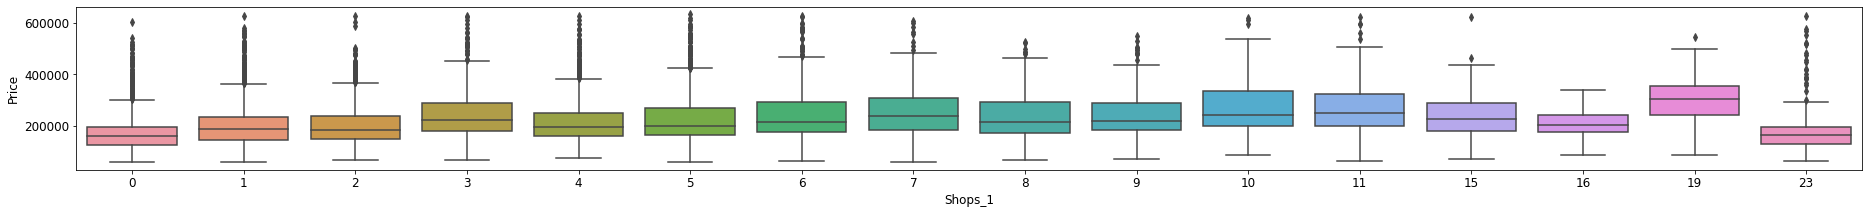

In [172]:
for var in train_df.select_dtypes(include=['int8']).columns.tolist(): 
  data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
  f, ax = plt.subplots(figsize=(32, 3))
  fig = sns.boxplot(x=var, y=TARGET_NAME, data=data)
#  высокие этажи подороже, точнее не первый этаж
#  flor to cat 0,4,9,12,22

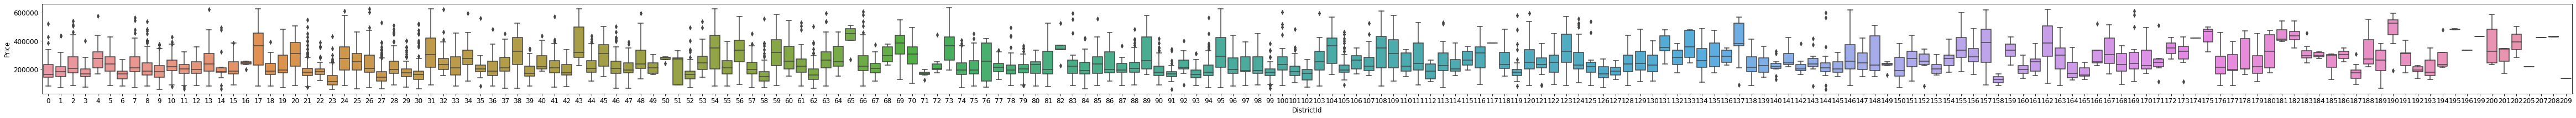

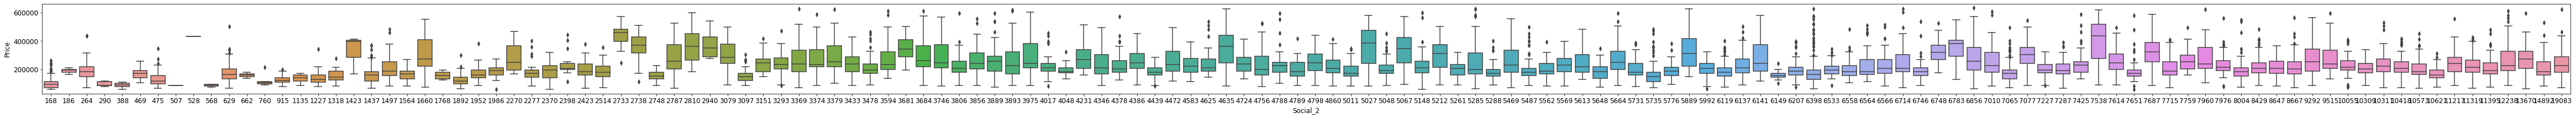

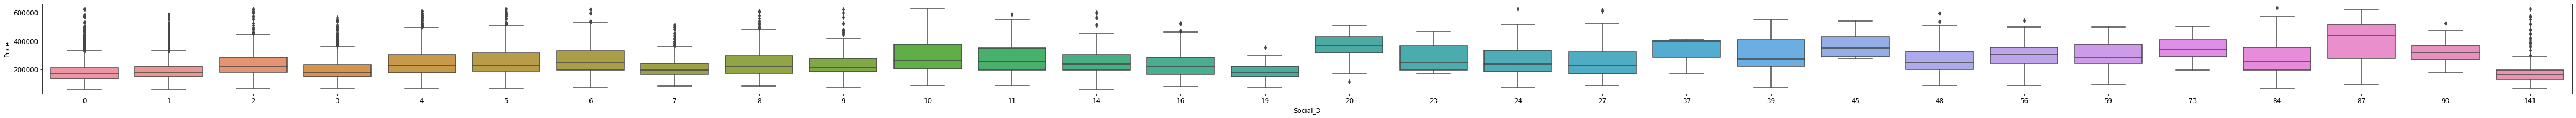

In [173]:
for var in train_df.select_dtypes(include=['int16']).columns.tolist(): 
  data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
  f, ax = plt.subplots(figsize=(82, 3))
  fig = sns.boxplot(x=var, y=TARGET_NAME, data=data)
#  Диапазон цен по районам,социальная инфраструктура

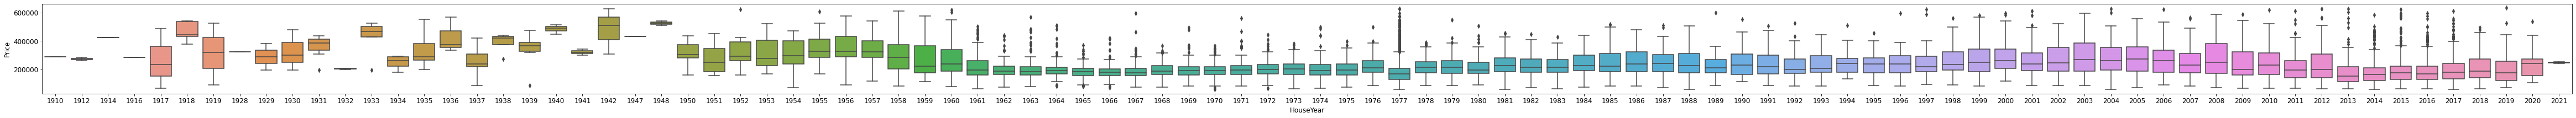

In [174]:
int32 = train_df.select_dtypes(include=['int32']).columns.tolist()
for var in int32: 
  data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
  f, ax = plt.subplots(figsize=(82, 3))
  fig = sns.boxplot(x=var, y=TARGET_NAME, data=data)
  # bins => 0, 1933, 1948, 1960, 1984, 1990, 2002, 2013

In [175]:
class DataPreprocessing(TransformerMixin, BaseEstimator):
    """Подготовка исходных данных"""   
    def __init__(self, **kwargs):
        super().__init__()
        """Параметры класса"""       
        options = {
            'min_room_size': 8,
            'life_sq_factor' : 0.9, 
            'kitchen_sq_factor' : 0.5, 
            'min_square' : 14,
            'max_square' : 650,
            'max_floor': 95,
            'max_rooms': 10,
            'min_kitchen': 1,
            'min_house_year': 1900 }   
         # 14-14*0.1
        options['min_lifesquare'] = options.get('min_square')-options.get('min_square')*(1-options.get('life_sq_factor'))
        options['max_lifesquare'] = options.get('max_square')*options.get('life_sq_factor')
        options['max_kitchen'] = (options.get('max_square')-options.get('max_lifesquare'))* options.get('kitchen_sq_factor')
        options.update(kwargs)
        print(f"PARAMS: options:{options}")
        self.medians=None
        self.current_year = datetime.now().year    
        self.options = options
        self.columns = None  
        self.districts_healthcare = None
        self.max_floors_by_district_year = None
        self.mean_floors_by_district_year = None
        self.median_floors_by_district_year = None

    def fit(self, X, y=None):
        """Сохранение статистик""" 
        X = X.copy()   
        self.medians = X.median()         
        # mean/median/max по району и году постройки        
        self.max_floors_by_district_year = X.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'HouseFloor': 'max'}).rename(columns={'HouseFloor': 'max_floors_district_year'})        
        self.mean_floors_by_district_year = X.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'HouseFloor': 'mean'}).rename(columns={'HouseFloor': 'mean_floors_district_year'})
        self.median_floors_by_district_year = X.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'HouseFloor': 'median'}).rename(columns={'HouseFloor': 'median_floors_district_year'})         
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()

        return self            
    
    def transform(self, X, y=None):
        """Трансформация данных"""
        X['Ecology_2'], uniq = pd.factorize(X['Ecology_2']) 
        X['Ecology_3'], uniq = pd.factorize(X['Ecology_3'])  
        X['Shops_2'], uniq = pd.factorize(X['Shops_2'])  

        # HouseYear  fix        
        X.HouseYear = np.clip(X.HouseYear, a_min=self.options.get('min_house_year'), a_max=self.current_year) 

        # Square limit
        X.Square=np.clip(X.Square, a_min=self.options.get("min_square"), a_max=self.options.get("max_square"))    

        # LifeSquare limit
        X.LifeSquare=np.clip(X.LifeSquare, a_min=self.options.get("min_lifesquare"), a_max=self.options.get("max_lifesquare"))

        condition = (X['LifeSquare'] > X['Square'])
        # swap LifeSquare<=>Square
        X.loc[condition, ['LifeSquare', 'Square']] = X.loc[condition, ['Square', 'LifeSquare']].values
        # fillna reduce square by some factor 0<factor<1
        X['LifeSquare'].fillna(X.Square * self.options.get("life_sq_factor"), inplace=True) 
        X.LifeSquare=np.clip(X.LifeSquare, a_min=self.options.get("min_lifesquare"), a_max=self.options.get("max_lifesquare"))

        # KitchenSquare       
        X.KitchenSquare = np.clip(X.KitchenSquare, a_min=self.options.get("a_min"), a_max=self.options.get("max_kitchen"))

        # кухни, размер которых больше разницы между общей и жилой площадью - заменяем на разницу между общей и жилой площадью*kitchen_sq_factor        
        kitchenCondition = (X['KitchenSquare'] > X['Square'] - X['LifeSquare']) 
        X.loc[kitchenCondition, 'KitchenSquare'] = ((X['Square'] - X['LifeSquare'])*self.options.get('kitchen_sq_factor')).apply(np.floor)

        # кухни, размер которых больше жилой площадью
        condition = (X['KitchenSquare'] > X['LifeSquare'])
        # swap LifeSquare<=>KitchenSquare
        X.loc[condition, ['LifeSquare', 'KitchenSquare']] = X.loc[condition, ['KitchenSquare', 'LifeSquare']].values
        np.clip(X.KitchenSquare, a_min=self.options.get("a_min"), a_max=self.options.get("max_kitchen"))

        # Rooms
        X.Rooms = np.clip(X.Rooms, a_min=1, a_max=self.options.get("max_rooms"))
        condition = ((X['Rooms'] == 0) | (X['Rooms'] > self.options.get("max_rooms")))  
        X.loc[condition, 'Rooms'] = (X.loc[condition, 'Square'] // self.options.get("min_room_size")).astype('int')  
 
        # Floor            
        X.Floor = np.clip(X.Floor, a_min=1, a_max=self.options.get("max_floor"))

        # HouseFloor       
        X.HouseFloor=np.clip(X.HouseFloor, a_min=0, a_max=self.options.get("max_floor"))   

        X = pd.merge(X, self.median_floors_by_district_year, on=['DistrictId', 'HouseYear'], how='left')
        X = pd.merge(X, self.mean_floors_by_district_year, on=['DistrictId', 'HouseYear'], how='left')
        X = pd.merge(X, self.max_floors_by_district_year, on=['DistrictId', 'HouseYear'], how='left')         
        X['mean_floors_district_year'] = X['mean_floors_district_year'].apply(np.ceil) 

        # Fill-in HouseFloor 0             
        X.loc[X['HouseFloor'] ==0, 'HouseFloor'] = X['mean_floors_district_year']
        X.loc[X['HouseFloor'] ==0, 'HouseFloor'] = X['max_floors_district_year']
        X.loc[X['HouseFloor'] ==0, 'HouseFloor'] = X['HouseFloor'].median() 
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))  

        # Healthcare          
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)

        # Round to max possible unit fraction Okruglim strannye dlinnye floats   
        X['Square'] = X['Square'].apply(np.ceil)
        X['LifeSquare'] = X['LifeSquare'].apply(np.ceil)

        X.drop(columns=['Id', 'max_floors_district_year','mean_floors_district_year','median_floors_district_year'], axis=1, inplace=True, errors='ignore')

        self.columns = list(X.columns)

        X.fillna(self.medians, inplace=True)
        return X

    def get_feature_names(self):
        return self.columns 

In [176]:
class FeatureGenetator(TransformerMixin, BaseEstimator): 
    def __init__(self):
      super().__init__()  
      self.district_size = None    
      self.floor_max = None
      self.columns = None 

    def fit(self, X, y=None):
      self.columns = list(X.columns)     
      X = X.copy()

      self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'}) 
      self.floor_max = X['Floor'].max() 
      return self

    def transform(self, X, y=None): 
 
      # DistrictSize
      X = X.merge(self.district_size, on='DistrictId', how='left')  
      X['DistrictSize'].fillna(5, inplace=True) 
      
      # More categorical features
      X = self.floor_to_cat(X)  # + столбец floor_cat
      self.new_columns = list(X.columns)  
      return X  

    def floor_to_cat(self, X):    
      bins =[0,4,9,12, 16, 22, self.floor_max]
      X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
      X['floor_cat'].fillna(-1, inplace=True) 
      return X  

    def get_feature_names(self):      
      zz = [el for el in self.new_columns if el not in self.columns]
      return zz

**# 7. Построение модели**

In [177]:
def load_preprossed(f_gen=False, **preprocess_config):
  print(f"f_gen:{f_gen}")

  train_df, test_df = load_data()
  X, y = get_X_y(train_df)
  print(f"X.shape: {X.shape} y.shape.shape: {y.shape}") 

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)
  print(f"X_train.shape: {X_train.shape} X_valid.shape: {X_valid.shape} test_df.shape: {test_df.shape}") 
  
  preprocessor = DataPreprocessing(**preprocess_config)
  preprocessor.fit(X_train)

  X_train = preprocessor.transform(X_train)
  X_valid = preprocessor.transform(X_valid)
  test_df = preprocessor.transform(test_df)

  if f_gen:
    features_gen = FeatureGenetator()
    features_gen.fit(X_train, y_train)

    X_train = features_gen.transform(X_train)
    X_valid = features_gen.transform(X_valid)
    test_df = features_gen.transform(test_df)

  return X_train, X_valid, y_train, y_valid, test_df

In [178]:
preprocess_config ={} # use default cleanup configurations

X_train, X_valid, y_train, y_valid, test_df = load_preprossed(f_gen=True, **preprocess_config) 

check_outliers(X_train)
check_outliers(X_valid)
check_outliers(test_df)

print(f"using features: {list(X_train.columns)}")

f_gen:True
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%
(10000, 20) (5000, 19)
X.shape: (10000, 19) y.shape.shape: (10000,)
X_train.shape: (6700, 19) X_valid.shape: (3300, 19) test_df.shape: (5000, 19)
PARAMS: options:{'min_room_size': 8, 'life_sq_factor': 0.9, 'kitchen_sq_factor': 0.5, 'min_square': 14, 'max_square': 650, 'max_floor': 95, 'max_rooms': 10, 'min_kitchen': 1, 'min_house_year': 1900, 'min_lifesquare': 12.6, 'max_lifesquare': 585.0, 'max_kitchen': 32.5}
HouseYear: [1912<=>2021]
Floor: [1<=>42] floor/housefloor Series([], Name: Floor, dtype: int64)
Rooms: [1.0<=>10.0]
Square: [14.0<=>642.0]
LifeSquare: [13.0 <=>585.0] LifeSquare/Square: Series([], Name: LifeSquare, dtype: float32) nan: Series([], Name: LifeSquare, dtype: float32)
KitchenSquare: [0.0 <=> 32.5] KitchenSquare>LifeSquare: Series([], Name: KitchenSquare, dtype

In [ ]:
# print(f"==============RandomForestRegressor")
# rf = RandomForestRegressor(random_state=21,
#                                 criterion='mse',
#                                 n_estimators=2000,
#                                 min_samples_split=5,
#                                 min_samples_leaf=1,
#                                 max_features='sqrt',
#                                 max_depth=50,
#                                 bootstrap=True)
# rf.fit(X_train, y_train)
# y_train_preds = rf.predict(X_train)
# y_test_preds = rf.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# print(f"==============GradientBoostingRegressor")
# gb = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=20,
#                                      min_samples_leaf=24,
#                                      random_state=21,  
#                                      n_estimators=265, 
#                                      max_features='sqrt', 
#                                      loss='huber', 
#                                      learning_rate=0.025)
# gb.fit(X_train, y_train)
# y_train_preds = gb.predict(X_train)
# y_test_preds = gb.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# print(f"==============LGBMRegressor")
# lgb = LGBMRegressor( random_state=21,
#                          num_leaves=13,
#                           learning_rate=0.02,
#                         #  max_bins=110, 
#                           n_estimators=650,
#                          max_depth=6,     
#                           verbose=-1)
# lgb.fit(X_train, y_train)
# y_train_preds = lgb.predict(X_train)
# y_test_preds = lgb.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# print(f"==============XGBRegressor")
# xgb = XGBRegressor(random_state=21,
#                       tree_method='hist',
#                       subsample=1.0,
#                       n_estimators=600,
#                       max_depth=3,
#                       importance_type='total_cover',
#                       colsample_bytree=1.0,
#                       booster='dart')
# xgb.fit(X_train, y_train)
# y_train_preds = xgb.predict(X_train)
# y_test_preds = xgb.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
# cv_score = cross_val_score(rf, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# print(cv_score, cv_score.mean())
# cv_score = cross_val_score(gb, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# print(cv_score, cv_score.mean()) 
# cv_score = cross_val_score(lgb, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# print(cv_score, cv_score.mean()) 
# cv_score = cross_val_score(xgb, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# print(cv_score, cv_score.mean())

**Model**

[11:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train R2:	0.884
Test R2:	0.767


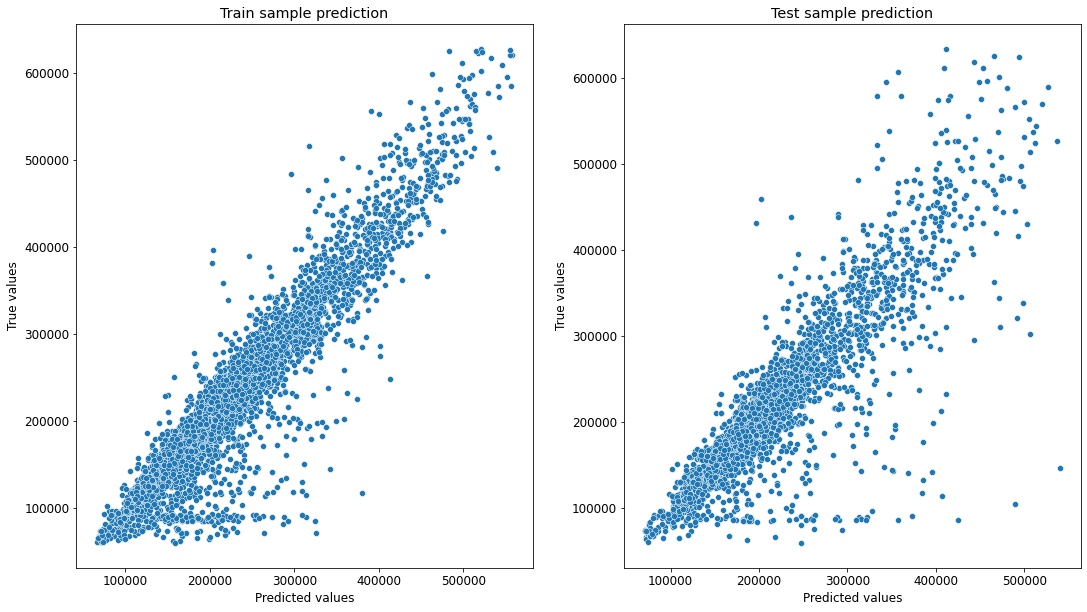

[11:16:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(array([0.75091044, 0.71325938, 0.74341623]), 0.7358620151107487)

In [179]:
rf = RandomForestRegressor(random_state=21,
                                criterion='mse',
                                n_estimators=2000,
                                min_samples_split=5,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                max_depth=50,
                                bootstrap=True)

gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=24,
                                     random_state=21,  
                                     n_estimators=265, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

lgb = LGBMRegressor( random_state=21,
                         num_leaves=13,
                          learning_rate=0.02,
                        #  max_bins=110, 
                         n_estimators=650,
                         max_depth=6,     
                         verbose=-1)

xgb = XGBRegressor(random_state=21,
                      tree_method='hist',
                      subsample=1.0,
                      n_estimators=600,
                      max_depth=3,
                      importance_type='total_cover',
                      colsample_bytree=1.0,
                      booster='dart')

voting = VotingRegressor([('r', rf), ('gb', gb), ('lgb', lgb), ('xgb', xgb)])
voting.fit(X_train, y_train)

y_train_preds = voting.predict(X_train)
y_test_preds = voting.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

cv_score = cross_val_score(voting, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score, cv_score.mean()

**8. Прогнозирование на тестовом датасете**

In [ ]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit.head()

In [ ]:
predictions = voting.predict(test_df)
predictions

array([164757.36090445, 125234.72863382, 143275.13873061, ...,
       147795.98258587, 190655.44027297, 269383.72823454])

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164757.360904
1,5925,125234.728634
2,960,143275.138731
3,3848,122862.002782
4,746,207643.422117


In [ ]:
submit.to_csv(DATASET_PATH+'voting4_submit.csv', index=False)